In [1]:
import numpy as np
import pandas as pd

import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [6]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [7]:
def init_models():
    model_lr = LogisticRegression(random_state=21)
    model_knn = KNeighborsClassifier()
    model_tree = DecisionTreeClassifier(random_state=21)
    model_xgb = xgb.XGBClassifier(random_state=21)
    model_lgbm = lgbm.LGBMClassifier(random_state=21)
    model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

    models = {
        'lr': model_lr,
        'knn': model_knn,
        'tree': model_tree,
        'xgb': model_xgb,
        'lgbm': model_lgbm,
        'cat': model_catb
    }
    return models

In [8]:
def get_metrics(report):
    f1_macro = report['macro avg']['f1-score']
    f1_0 = report['0']['f1-score']
    f1_1 = report['1']['f1-score']
    return f1_macro, f1_0, f1_1

In [9]:
def run_experiment(X_train, X_test, y_train, y_test, method='not'):
    assert method in ['not', 'over', 'under', 'tomek', 'smote'], 'Неправильный метод сэмплирования'
    
    models = init_models()
    
    stata = pd.DataFrame()
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        report_train = classification_report(y_train, pred_train, output_dict=True)
        report_test = classification_report(y_test, pred_test, output_dict=True)
        f1_macro_train, f1_0_train, f1_1_train = get_metrics(report_train)
        f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)

        stata = stata.append({
            'model_name': name,
            f'f1_macro_train_{method}': f1_macro_train,
            f'f1_macro_test_{method}': f1_macro_test,
            f'f1_0_train_{method}': f1_0_train,
            f'f1_0_test_{method}': f1_0_test,
            f'f1_1_train_{method}': f1_1_train,
            f'f1_1_test_{method}': f1_1_test
        }, ignore_index=True)
    return stata, models

**Пути к директориям и файлам**

In [10]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [11]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0


In [12]:
train_df.shape

(7500, 17)

In [13]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [14]:
train_df_base_solution = train_df.copy()
train_df_base_solution.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0


#### заполнение количественных признаков медианами для базового решения

In [15]:
train_df_base_solution['Annual Income'] =\
    train_df_base_solution['Annual Income'].fillna(train_df_base_solution['Annual Income'].median())

train_df_base_solution['Months since last delinquent'] =\
    train_df_base_solution['Months since last delinquent'].fillna(train_df_base_solution['Months since last delinquent'].median())

train_df_base_solution['Credit Score'] =\
    train_df_base_solution['Credit Score'].fillna(train_df_base_solution['Credit Score'].median())

In [16]:
print(train_df_base_solution['Annual Income'].isna().sum())
print(train_df_base_solution['Months since last delinquent'].isna().sum())
print(train_df_base_solution['Credit Score'].isna().sum())

0
0
0


#### заполнение категориальных признаков модами для базового решения

In [17]:
train_df_base_solution['Years in current job'] =\
    train_df_base_solution['Years in current job'].fillna(train_df_base_solution['Years in current job'].mode()[0])
train_df_base_solution['Bankruptcies'] =\
    train_df_base_solution['Bankruptcies'].fillna(train_df_base_solution['Bankruptcies'].mode()[0])

In [18]:
print(train_df_base_solution['Years in current job'].isna().sum())
print(train_df_base_solution['Bankruptcies'].isna().sum())

0
0


#### проверка на отсутствие пропусков в датафрейме для базового решения

In [19]:
train_df_base_solution.isna().sum().sum()

0

In [20]:
train_df_base_solution.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

#### получение get_dummies для категориальных переменных и удаление переменной из которой делали get_dummies

In [21]:
list_of_features_to_get_dummies = ['Home Ownership',
                                   'Years in current job',
                                   'Purpose', 
                                   'Term']

for feature in list_of_features_to_get_dummies:
    # получение get_dummies
    train_df_base_solution = pd.concat([train_df_base_solution, 
                                        pd.get_dummies(pd.get_dummies(train_df_base_solution[feature],
                                        prefix=feature))],
                                        axis=1)
    # удаление признака
    train_df_base_solution = train_df_base_solution.drop([feature], axis=1)

In [22]:
train_df_base_solution.dtypes

Annual Income                     float64
Tax Liens                         float64
Number of Open Accounts           float64
Years of Credit History           float64
Maximum Open Credit               float64
Number of Credit Problems         float64
Months since last delinquent      float64
Bankruptcies                      float64
Current Loan Amount               float64
Current Credit Balance            float64
Monthly Debt                      float64
Credit Score                      float64
Credit Default                      int64
Home Ownership_Have Mortgage        uint8
Home Ownership_Home Mortgage        uint8
Home Ownership_Own Home             uint8
Home Ownership_Rent                 uint8
Years in current job_1 year         uint8
Years in current job_10+ years      uint8
Years in current job_2 years        uint8
Years in current job_3 years        uint8
Years in current job_4 years        uint8
Years in current job_5 years        uint8
Years in current job_6 years      

#### Разбиение на train и test

In [23]:
TARGET_NAME = 'Credit Default'

X = train_df_base_solution.drop(TARGET_NAME, axis=1)
y = train_df_base_solution[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y
                                                   )

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

#### Масштабрование данных

In [24]:
scaler = StandardScaler()

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

X_train_norm = scaler.fit_transform(X_train_norm)
X_test_norm = scaler.transform(X_test_norm)

In [25]:
model_lr = LogisticRegression()
model_lr.fit(X_train_norm, y_train)

evaluate_preds(model_lr, X_train_norm, X_test_norm, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.97      0.86      3771
           1       0.81      0.29      0.43      1479

    accuracy                           0.78      5250
   macro avg       0.80      0.63      0.65      5250
weighted avg       0.79      0.78      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1616
           1       0.77      0.25      0.38       634

    accuracy                           0.77      2250
   macro avg       0.77      0.61      0.62      2250
weighted avg       0.77      0.77      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1569   47
1                474  160


In [26]:
model_tree = DecisionTreeClassifier(random_state=21,
                                    class_weight={0:1, 1:2.55},
                                    max_depth=4
                                    )
model_tree.fit(X_train, y_train)

evaluate_preds(model_tree, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      3771
           1       0.53      0.51      0.52      1479

    accuracy                           0.73      5250
   macro avg       0.67      0.67      0.67      5250
weighted avg       0.73      0.73      0.73      5250

TEST

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1616
           1       0.51      0.49      0.50       634

    accuracy                           0.72      2250
   macro avg       0.65      0.65      0.65      2250
weighted avg       0.72      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1312  304
1                322  312


# ТЕКУЩИЕ ВОЗМОЖНОСТИ

In [27]:
TARGET_NAME = 'Credit Default'

In [28]:
def generate_dummies_from_home_ownership(X):
    X['G_home_ownership_home_mortgage'] = 0
    X.loc[X['Home Ownership'] == 'Home Mortgage', 'G_home_ownership_home_mortgage'] = 1
    
    X['G_home_ownership_rent'] = 0
    X.loc[X['Home Ownership'] == 'Rent', 'G_home_ownership_rent'] = 1
    
    X['G_home_ownership_own_home'] = 0
    X.loc[X['Home Ownership'] == 'Own Home', 'G_home_ownership_own_home'] = 1
    
    X['G_home_ownership_have_mortgage'] = 0
    X.loc[X['Home Ownership'] == 'Have Mortgage', 'G_home_ownership_have_mortgage'] = 1
    
    X['G_home_ownership_other'] = 0
    X.loc[~X['Home Ownership'].isin(['Home Mortgage', 'Rent', 'Own Home', 'Have Mortgage']), 'G_home_ownership_other'] = 1
    
    return X

In [29]:
def generate_G_home_ownership_reduced_to_binary(X):
    X['G_home_ownership_reduced_to_binary'] = 0
    X.loc[~X['Home Ownership'].isin(['Own Home', 'Rent']), 'G_home_ownership_reduced_to_binary'] = 1
    return X

In [30]:
def generate_G_years_in_current_job_reduced_to_binary(X):
    X['G_years_in_current_job_reduced_to_binary'] = 0
    X.loc[X['Years in current job'].isna(), 'G_years_in_current_job_reduced_to_binary'] = 1
    return X

In [31]:
def generate_G_purpose_reduced_to_binary(X):
    X['G_purpose_reduced_to_binary'] = 0
    X.loc[X['Purpose'].isin(['business loan', 'small business']), 'G_purpose_reduced_to_binary'] = 1
    return X

In [32]:
def generate_G_term_transformed_to_binary(X):
    X['G_term_transformed_to_binary'] = 0
    X.loc[X['Term'] == 'Long Term', 'G_term_transformed_to_binary'] = 1
    return X

In [33]:
def generate_G_tax_liens_reduced_to_binary(X):
    X['G_tax_liens_reduced_to_binary'] = 0
    X.loc[X['Tax Liens'].isin([2, 3, 4, 5]), 'G_tax_liens_reduced_to_binary'] = 1   
    return X

In [34]:
def generate_G_number_of_credit_problems_reduced_to_binary(X):
    X['G_number_of_credit_problems_reduced_to_binary'] = 0
    X.loc[~X['Number of Credit Problems'].isin([0, 1]), 'G_number_of_credit_problems_reduced_to_binary'] = 1   
    return X

In [35]:
def generate_G_bankruptcies_reduced_to_binary(X):
    X['G_bankruptcies_reduced_to_binary'] = 0
    X.loc[~X['Number of Credit Problems'].isin([0, 1]), 'G_bankruptcies_reduced_to_binary'] = 1  
    return X

In [36]:
def generate_G_annual_income_was_nan(X):
    X['G_annual_income_was_nan'] = 0
    X.loc[X['Annual Income'].isna(), 'G_annual_income_was_nan'] = 1  
    return X

In [37]:
def generate_target_encoded_feature_for_a_numerical_feature(df, number_of_categories, 
                                                            feature_name, target_name, 
                                                            push_right_min_outliers_in_feature_name, 
                                                            push_left_max_outliers_in_feature_name):
    # функция генерирует новый признак
    # путём разбиения пространства оригинального признака на заданное количество равных интервалов
    # и просчитывает пропорцию / вероятность  объектов с целевой переменной == 1
    # к общему числу объектов на каждом интервале
    # с присвоением значения вероятности какждому объекту в виде значения нового признака.
    # NB! если в оригинальном признаке есть пропуски, то для них будет создана отдельная,
    # дополнительная подкатегория внутри нового признака, вдобавок к заданному количеству в параметре number_of_categories.
    # при генерации нового признака используя действительную функцию
    # следует проверить целесообразность такого действия 
    # при помощи другой, написанной выше функции check_whether_categorization_with_target_encoding_is_valid
    # NB! функция может присваивать 2.5% минимальных и 2.5% максимальных значений (выбросы) в оригинальном признаке
    # значения равные 2.5% от минимума и 2.5% от максимума соответственно.
    
    X = df.copy()
    
    # присваивание 2.5% минимальных и 2.5% максимальных значений (выбросам) в оригинальном признаке
    # значений равных 2.5% от минимума и 2.5% от максимума соответственно
    value_q_0025 = np.quantile(X.loc[~X[feature_name].isna(), feature_name], q=0.025)
    value_q_0975 = np.quantile(X.loc[~X[feature_name].isna(), feature_name], q=0.975)
    
    if push_right_min_outliers_in_feature_name:
        X.loc[X[feature_name] < value_q_0025, feature_name] = value_q_0025
        
    if push_left_max_outliers_in_feature_name:
        X.loc[X[feature_name] > value_q_0975, feature_name] = value_q_0975
    
    # выявление минимального и максимального значений на пространстве значений исходного признака
    feature_min_value = X[feature_name].min()
    feature_max_value = X[feature_name].max()
    
    # создание интервалов из пространства значений исходного признака
    limits_of_categories = np.linspace(feature_min_value, feature_max_value, number_of_categories + 1)
    
    # генерация имени нового признака
    new_feature_name = 'G_' + f'{feature_name}'.lower().replace(' ', '_') + '_target_encoded'
    
    # заполнение нового признака средним значением целевой переменной -
    # перестраховка, чтобы избежать возможности пропусков
    X[new_feature_name] = X[target_name].mean()
    
    # заполнение пропусков в признаке средним значением целевой переменной на объектах,
    # где есть пропуски в признаках
    X.loc[df[feature_name].isna(), new_feature_name] = X.loc[df[feature_name].isna(), target_name].mean()
    
    # присвоение каждому объекту значения нового признака равного вероятности 
    # появления значения целевой переменной == 1 на заданном интервале оригинального признака
    i = 0
    while True:
        if i == number_of_categories:
            break

        try:
            category_stat =\
                X.loc[(df[feature_name] >= limits_of_categories[i]) & 
                      (df[feature_name] < limits_of_categories[i + 1])][target_name].value_counts()
            
            X.loc[(df[feature_name] >= limits_of_categories[i]) & 
                  (df[feature_name] < limits_of_categories[i + 1]), 
                  new_feature_name] = round((category_stat[1] / sum(category_stat)), 3) 
            
        except:
            None

        i += 1
        
    return X

In [38]:
df = train_df.copy()

In [39]:
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0


In [40]:
df = generate_dummies_from_home_ownership(df)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,G_home_ownership_home_mortgage,G_home_ownership_rent,G_home_ownership_own_home,G_home_ownership_have_mortgage,G_home_ownership_other
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,99999999.0,47386.0,7914.0,749.0,0,0,0,1,0,0


In [41]:
df = generate_G_home_ownership_reduced_to_binary(df)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,G_home_ownership_home_mortgage,G_home_ownership_rent,G_home_ownership_own_home,G_home_ownership_have_mortgage,G_home_ownership_other,G_home_ownership_reduced_to_binary
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,47386.0,7914.0,749.0,0,0,0,1,0,0,0


In [42]:
df = generate_G_years_in_current_job_reduced_to_binary(df)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Monthly Debt,Credit Score,Credit Default,G_home_ownership_home_mortgage,G_home_ownership_rent,G_home_ownership_own_home,G_home_ownership_have_mortgage,G_home_ownership_other,G_home_ownership_reduced_to_binary,G_years_in_current_job_reduced_to_binary
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,7914.0,749.0,0,0,0,1,0,0,0,1


In [43]:
df = generate_G_purpose_reduced_to_binary(df)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Score,Credit Default,G_home_ownership_home_mortgage,G_home_ownership_rent,G_home_ownership_own_home,G_home_ownership_have_mortgage,G_home_ownership_other,G_home_ownership_reduced_to_binary,G_years_in_current_job_reduced_to_binary,G_purpose_reduced_to_binary
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,749.0,0,0,0,1,0,0,0,1,0


In [44]:
df = generate_G_term_transformed_to_binary(df)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Default,G_home_ownership_home_mortgage,G_home_ownership_rent,G_home_ownership_own_home,G_home_ownership_have_mortgage,G_home_ownership_other,G_home_ownership_reduced_to_binary,G_years_in_current_job_reduced_to_binary,G_purpose_reduced_to_binary,G_term_transformed_to_binary
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,0,0,0,1,0,0,0,1,0,0


In [45]:
df = generate_G_tax_liens_reduced_to_binary(df)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,G_home_ownership_home_mortgage,G_home_ownership_rent,G_home_ownership_own_home,G_home_ownership_have_mortgage,G_home_ownership_other,G_home_ownership_reduced_to_binary,G_years_in_current_job_reduced_to_binary,G_purpose_reduced_to_binary,G_term_transformed_to_binary,G_tax_liens_reduced_to_binary
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,0,0,1,0,0,0,1,0,0,0


In [46]:
df = generate_G_number_of_credit_problems_reduced_to_binary(df)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,G_home_ownership_rent,G_home_ownership_own_home,G_home_ownership_have_mortgage,G_home_ownership_other,G_home_ownership_reduced_to_binary,G_years_in_current_job_reduced_to_binary,G_purpose_reduced_to_binary,G_term_transformed_to_binary,G_tax_liens_reduced_to_binary,G_number_of_credit_problems_reduced_to_binary
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,0,1,0,0,0,1,0,0,0,0


In [47]:
df = generate_G_bankruptcies_reduced_to_binary(df)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,G_home_ownership_own_home,G_home_ownership_have_mortgage,G_home_ownership_other,G_home_ownership_reduced_to_binary,G_years_in_current_job_reduced_to_binary,G_purpose_reduced_to_binary,G_term_transformed_to_binary,G_tax_liens_reduced_to_binary,G_number_of_credit_problems_reduced_to_binary,G_bankruptcies_reduced_to_binary
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,1,0,0,0,1,0,0,0,0,0


In [48]:
df = generate_G_annual_income_was_nan(df)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,G_home_ownership_have_mortgage,G_home_ownership_other,G_home_ownership_reduced_to_binary,G_years_in_current_job_reduced_to_binary,G_purpose_reduced_to_binary,G_term_transformed_to_binary,G_tax_liens_reduced_to_binary,G_number_of_credit_problems_reduced_to_binary,G_bankruptcies_reduced_to_binary,G_annual_income_was_nan
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,0,0,0,1,0,0,0,0,0,0


In [49]:
df.isna().sum()

Home Ownership                                      0
Annual Income                                    1557
Years in current job                              371
Tax Liens                                           0
Number of Open Accounts                             0
Years of Credit History                             0
Maximum Open Credit                                 0
Number of Credit Problems                           0
Months since last delinquent                     4081
Bankruptcies                                       14
Purpose                                             0
Term                                                0
Current Loan Amount                                 0
Current Credit Balance                              0
Monthly Debt                                        0
Credit Score                                     1557
Credit Default                                      0
G_home_ownership_home_mortgage                      0
G_home_ownership_rent       

In [50]:
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Annual Income',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=True, 
                                                             push_left_max_outliers_in_feature_name=True)
df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,G_home_ownership_other,G_home_ownership_reduced_to_binary,G_years_in_current_job_reduced_to_binary,G_purpose_reduced_to_binary,G_term_transformed_to_binary,G_tax_liens_reduced_to_binary,G_number_of_credit_problems_reduced_to_binary,G_bankruptcies_reduced_to_binary,G_annual_income_was_nan,G_annual_income_target_encoded
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,0,0,1,0,0,0,0,0,0,0.34


In [51]:
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Current Loan Amount',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=False)

In [52]:
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Maximum Open Credit',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=True, 
                                                             push_left_max_outliers_in_feature_name=True)

In [53]:
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=5, 
                                                             feature_name='Number of Open Accounts',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=True)

In [54]:
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Years of Credit History',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=False)

In [55]:
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Monthly Debt',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=False)

In [56]:
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Months since last delinquent',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=False)

In [57]:
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=20, 
                                                             feature_name='Credit Score',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=False)

#### заполнение количественных признаков медианами для базового решения

In [58]:
df['Annual Income'] = df['Annual Income'].fillna(df['Annual Income'].median())

df['Months since last delinquent'] = df['Months since last delinquent'].fillna(df['Months since last delinquent'].median())

df['Credit Score'] = df['Credit Score'].fillna(df['Credit Score'].median())

In [59]:
print(df['Annual Income'].isna().sum())
print(df['Months since last delinquent'].isna().sum())
print(df['Credit Score'].isna().sum())

0
0
0


#### заполнение категориальных признаков модами для базового решения

In [60]:
df['Years in current job'] = df['Years in current job'].fillna(df['Years in current job'].mode()[0])
df['Bankruptcies'] = df['Bankruptcies'].fillna(df['Bankruptcies'].mode()[0])

In [61]:
print(df['Years in current job'].isna().sum())
print(df['Bankruptcies'].isna().sum())

0
0


#### проверка на отсутствие пропусков в датафрейме для базового решения

In [62]:
df.isna().sum().sum()

0

In [63]:
df.dtypes

Home Ownership                                    object
Annual Income                                    float64
Years in current job                              object
Tax Liens                                        float64
Number of Open Accounts                          float64
Years of Credit History                          float64
Maximum Open Credit                              float64
Number of Credit Problems                        float64
Months since last delinquent                     float64
Bankruptcies                                     float64
Purpose                                           object
Term                                              object
Current Loan Amount                              float64
Current Credit Balance                           float64
Monthly Debt                                     float64
Credit Score                                     float64
Credit Default                                     int64
G_home_ownership_home_mortgage 

#### Разбиение на train и test

In [64]:
TARGET_NAME = 'Credit Default'

X = df.drop(TARGET_NAME, axis=1)
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y
                                                   )

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

# ПРИСВОИМ ОБЪЕКТАМ С Current Loan Amount' == 99999999.0 ЗНАЧЕНИЕ TARGET == 0, А ОБЪЕКТАМ С Credit Score > 1000 ЗНАЧЕНИЕ TARGET == 1

In [65]:
X_train.shape

(5250, 37)

In [66]:
X_test.shape

(2250, 37)

In [67]:
X_train[X_train['Current Loan Amount'] == 99999999.0]['Current Loan Amount'].count()

603

In [68]:
X_test[X_test['Current Loan Amount'] == 99999999.0]['Current Loan Amount'].count()

267

In [69]:
indexes_of_X_train_with_target_0 = X_train[X_train['Current Loan Amount'] == 99999999.0]['Current Loan Amount'].index
indexes_of_X_test_with_target_0 = X_test[X_test['Current Loan Amount'] == 99999999.0]['Current Loan Amount'].index

In [70]:
# X_train = X_train.drop(['Current Loan Amount'], axis=1)
# X_test = X_test.drop(['Current Loan Amount'], axis=1)

In [71]:
y_train[indexes_of_X_train_with_target_0].value_counts()

0    603
Name: Credit Default, dtype: int64

In [72]:
y_test[indexes_of_X_test_with_target_0].value_counts()

0    267
Name: Credit Default, dtype: int64

In [73]:
X_train[X_train['Credit Score'] > 1000]['Credit Score'].count()

285

In [74]:
X_test[X_test['Credit Score'] > 1000]['Credit Score'].count()

115

In [75]:
indexes_of_X_train_with_target_1 = X_train[X_train['Credit Score'] > 1000]['Credit Score'].index
indexes_of_X_test_with_target_1 = X_test[X_test['Credit Score'] > 1000]['Credit Score'].index

In [76]:
# X_train = X_train.drop(['Credit Score'], axis=1)
# X_test = X_test.drop(['Credit Score'], axis=1)

In [77]:
X_train_reduced = X_train.drop(indexes_of_X_train_with_target_0)
X_train_reduced = X_train.drop(indexes_of_X_train_with_target_1)

y_train_reduced = y_train.drop(indexes_of_X_train_with_target_0)
y_train_reduced = y_train.drop(indexes_of_X_train_with_target_1)

X_test_reduced = X_test.drop(indexes_of_X_test_with_target_0)
X_test_reduced = X_test.drop(indexes_of_X_test_with_target_1)

y_test_reduced = y_test.drop(indexes_of_X_test_with_target_0)
y_test_reduced = y_test.drop(indexes_of_X_test_with_target_1)

In [78]:
X_train.shape

(5250, 37)

In [79]:
X_test.shape

(2250, 37)

In [80]:
y_train.value_counts()

0    3771
1    1479
Name: Credit Default, dtype: int64

In [81]:
y_test.value_counts()

0    1616
1     634
Name: Credit Default, dtype: int64

In [82]:
X_train_reduced.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'G_home_ownership_home_mortgage',
       'G_home_ownership_rent', 'G_home_ownership_own_home',
       'G_home_ownership_have_mortgage', 'G_home_ownership_other',
       'G_home_ownership_reduced_to_binary',
       'G_years_in_current_job_reduced_to_binary',
       'G_purpose_reduced_to_binary', 'G_term_transformed_to_binary',
       'G_tax_liens_reduced_to_binary',
       'G_number_of_credit_problems_reduced_to_binary',
       'G_bankruptcies_reduced_to_binary', 'G_annual_income_was_nan',
       'G_annual_income_target_encoded',
       'G_current_loan_amount_target_encoded',
       'G_maximum_open_credit_target_encoded',
   

In [83]:
list_of_columns_to_drop = [
                            'Home Ownership', 
                           'Annual Income', 
                           'Years in current job', 
                           'Tax Liens',
                           'Number of Open Accounts', 
                           'Years of Credit History',
                           'Maximum Open Credit', 
                           'Number of Credit Problems',
                           'Months since last delinquent', 
                           'Bankruptcies', 
                           'Purpose', 
                           'Term',
                           'Current Loan Amount', 
                           'Current Credit Balance', 
                           'Monthly Debt',
#                            'Credit Score', 
#                            'G_home_ownership_home_mortgage',
#                            'G_home_ownership_rent', 
#                            'G_home_ownership_own_home',
#                            'G_home_ownership_have_mortgage', 
#                            'G_home_ownership_other',
#                            'G_home_ownership_reduced_to_binary',
#                            'G_years_in_current_job_reduced_to_binary',
#                            'G_purpose_reduced_to_binary', 
#                            'G_term_transformed_to_binary',
#                            'G_tax_liens_reduced_to_binary',
#                            'G_number_of_credit_problems_reduced_to_binary',
#                            'G_bankruptcies_reduced_to_binary', 
                           'G_annual_income_was_nan',
#                            'G_annual_income_target_encoded',
#                            'G_current_loan_amount_target_encoded',
#                            'G_maximum_open_credit_target_encoded',
#                            'G_number_of_open_accounts_target_encoded',
#                            'G_years_of_credit_history_target_encoded',
#                            'G_monthly_debt_target_encoded',
#                            'G_months_since_last_delinquent_target_encoded',
#                            'G_credit_score_target_encoded'
                          ]

In [84]:
X_train_reduced = X_train_reduced.drop(list_of_columns_to_drop, axis=1)
X_test_reduced = X_test_reduced.drop(list_of_columns_to_drop, axis=1)

In [85]:
CAT_FEATURE_NAMES =['Home Ownership', 
                           'Years in current job', 
                           'Tax Liens',
                           'Years of Credit History',
                           'Number of Credit Problems',
                           'Bankruptcies', 
                           'Purpose', 
                           'Term',
                           ]

In [86]:
# CAT_FEATURE_NAMES =['G_home_ownership_home_mortgage', 
#                     'G_home_ownership_reduced_to_binary', 
#                     'G_years_in_current_job_reduced_to_binary', 
#                     'G_purpose_reduced_to_binary', 
#                     'G_term_transformed_to_binary', 
#                     'G_tax_liens_reduced_to_binary', 
#                     'G_number_of_credit_problems_reduced_to_binary', 
#                     'G_bankruptcies_reduced_to_binary', 
#                     'Home Ownership']

In [87]:
# X_train_reduced['Number of Credit Problems'] = X_train_reduced['Number of Credit Problems'].astype(int)
# X_train_reduced['Bankruptcies'] = X_train_reduced['Bankruptcies'].astype(int)
# X_train_reduced['Years of Credit History'] = X_train_reduced['Years of Credit History'].astype(int)
# X_train_reduced['Tax Liens'] = X_train_reduced['Tax Liens'].astype(int)

# X_test_reduced['Number of Credit Problems'] = X_test_reduced['Number of Credit Problems'].astype(int)
# X_test_reduced['Bankruptcies'] = X_test_reduced['Bankruptcies'].astype(int)
# X_test_reduced['Years of Credit History'] = X_test_reduced['Years of Credit History'].astype(int)
# X_test_reduced['Tax Liens'] = X_test_reduced['Tax Liens'].astype(int)

In [88]:
X_train_reduced.dtypes

Credit Score                                     float64
G_home_ownership_home_mortgage                     int64
G_home_ownership_rent                              int64
G_home_ownership_own_home                          int64
G_home_ownership_have_mortgage                     int64
G_home_ownership_other                             int64
G_home_ownership_reduced_to_binary                 int64
G_years_in_current_job_reduced_to_binary           int64
G_purpose_reduced_to_binary                        int64
G_term_transformed_to_binary                       int64
G_tax_liens_reduced_to_binary                      int64
G_number_of_credit_problems_reduced_to_binary      int64
G_bankruptcies_reduced_to_binary                   int64
G_annual_income_target_encoded                   float64
G_current_loan_amount_target_encoded             float64
G_maximum_open_credit_target_encoded             float64
G_number_of_open_accounts_target_encoded         float64
G_years_of_credit_history_targe

#### удаление объектов

In [89]:
# df = df.drop(['Home Ownership', 
#               'Years in current job', 
#               'Purpose', 
#               'Term'], axis=1)

# df = df.drop(['Annual Income', 
#               'Tax Liens', 
#               'Number of Open Accounts', 
#               'Years of Credit History', 
#               'Maximum Open Credit', 
#               'Number of Credit Problems', 
#               'Months since last delinquent',
#               'Bankruptcies'], axis=1)

# df = df.drop([
#                 'Current Credit Balance',
#               'Monthly Debt',
# #               'Credit Score'
# ], axis=1)

## model

#### LogisticRegression

In [90]:
# scaler = StandardScaler()

# X_train_reduced = scaler.fit_transform(X_train_reduced)
# X_test_reduced = scaler.transform(X_test_reduced)

# model = LogisticRegression(random_state=21, class_weight={0:1, 1:2.54})

#### DecisionTreeClassifier

In [91]:
model = DecisionTreeClassifier(random_state=21,
                                    class_weight={0:1, 1:2.54},
                                    max_depth=4)

#### XGBClassifier

In [92]:
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from xgboost import XGBClassifier

In [93]:
# %%time
# model = xgb.XGBClassifier(random_state=21, 
#                           n_estimators=20
#                           )

#### LightGBM

In [94]:
from lightgbm import LGBMClassifier

In [95]:
# %%time
# model = lgbm.LGBMClassifier(random_state=21, 
#                             class_weight={0:1, 1:2.54},
#                             n_estimators=5
#                            )

#### CatBoost

In [96]:
from catboost import CatBoostClassifier

In [97]:
disbalance = y_train_reduced.value_counts()[0] / y_train_reduced.value_counts()[1]
disbalance

3.158291457286432

In [98]:
%%time
model = catb.CatBoostClassifier(silent=True, 
#                                 cat_features=CAT_FEATURE_NAMES,
                                one_hot_max_size=20,
                                class_weights=[1, disbalance],
                                random_state=21)

Wall time: 22.5 ms


In [99]:
# model = catb.CatBoostClassifier(silent=True, random_state=21,
#                                      class_weights=[1, disbalance],
#                                      eval_metric='F1',
#                                      cat_features=CAT_FEATURE_NAMES,
#                                 one_hot_max_size=10,
#                                      early_stopping_rounds=20,
#                                      use_best_model=True,
#                                      custom_metric=['Precision', 'Recall']
#                                     )


In [100]:
model.fit(X_train_reduced, y_train_reduced)
# model.fit(X_train_reduced, y_train_reduced, plot=True, eval_set=(X_test_reduced, y_test_reduced))

y_train_pred_reduced = model.predict(X_train_reduced)
y_test_pred_reduced = model.predict(X_test_reduced)

In [101]:
y_train_pred = y_train.copy()
y_test_pred = y_test.copy()

In [102]:
np.array(y_test_pred)

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [103]:
y_train_pred.loc[y_train_reduced.index] = y_train_pred_reduced
y_train_pred.loc[indexes_of_X_train_with_target_0] = 0
y_train_pred.loc[indexes_of_X_train_with_target_1] = 1

y_test_pred.loc[y_test_reduced.index] = y_test_pred_reduced
y_test_pred.loc[indexes_of_X_test_with_target_0] = 0
y_test_pred.loc[indexes_of_X_test_with_target_1] = 1

y_train_pred = np.array(y_train_pred)
y_test_pred = np.array(y_test_pred)

In [104]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.76      0.84      3771
           1       0.59      0.89      0.71      1479

    accuracy                           0.80      5250
   macro avg       0.77      0.83      0.78      5250
weighted avg       0.85      0.80      0.81      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.67      0.74      1616
           1       0.44      0.65      0.53       634

    accuracy                           0.67      2250
   macro avg       0.64      0.66      0.63      2250
weighted avg       0.72      0.67      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1087  529
1                220  414


#### Ничего не делаем с данными

In [105]:
%%time
stata_not_balanced, models_not_balanced = run_experiment(X_train_reduced, 
                                                         X_test_reduced, 
                                                         y_train_reduced, 
                                                         y_test_reduced, 
                                                         method='not')
stata_not_balanced

[10:17:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 7.64 s


,f1_0_test_not,f1_0_train_not,f1_1_test_not,f1_1_train_not,f1_macro_test_not,f1_macro_train_not,model_name
0,0.854878,0.861781,0.130933,0.177747,0.492906,0.519764,lr
1,0.821119,0.880639,0.228856,0.459053,0.524988,0.669846,knn
2,0.784606,0.990529,0.337786,0.969072,0.561196,0.979800,tree
3,0.840538,0.929592,0.283140,0.711499,0.561839,0.820545,xgb
4,0.850932,0.904009,0.274725,0.558376,0.562828,0.731192,lgbm
5,0.852091,0.902466,0.254597,0.526812,0.553344,0.714639,cat


#### Oversampling

In [106]:
df_for_balancing = pd.concat([X_train_reduced, y_train_reduced], axis=1)
TARGET_NAME = 'Credit Default'

df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    3582
Name: Credit Default, dtype: int64

In [107]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [108]:
%%time
stata_balanced_over, models_over = run_experiment(X_train_balanced, 
                                                  X_test_reduced, 
                                                  y_train_balanced, 
                                                  y_test_reduced, 
                                                  method='over')
stata_balanced_over

[10:17:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 18.4 s


,f1_0_test_over,f1_0_train_over,f1_1_test_over,f1_1_train_over,f1_macro_test_over,f1_macro_train_over,model_name
0,0.743729,0.668266,0.427273,0.612618,0.585501,0.640442,lr
1,0.660870,0.781033,0.380132,0.820633,0.520501,0.800833,knn
2,0.778465,0.987079,0.310212,0.986526,0.544339,0.986802,tree
3,0.772303,0.884574,0.393133,0.884228,0.582718,0.884401,xgb
4,0.762467,0.836983,0.407529,0.834975,0.584998,0.835979,lgbm
5,0.765789,0.841477,0.421138,0.840829,0.593464,0.841153,cat


#### Undersampling

In [109]:
df_for_balancing = pd.concat([X_train_reduced, y_train_reduced], axis=1)
TARGET_NAME = 'Credit Default'

df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under')
    
df_balanced[TARGET_NAME].value_counts()

1    1194
0    1194
Name: Credit Default, dtype: int64

In [110]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [111]:
%%time
stata_balanced_under, models_under = run_experiment(X_train_balanced, 
                                                  X_test_reduced, 
                                                  y_train_balanced, 
                                                  y_test_reduced, 
                                                  method='under')
stata_balanced_under

[10:17:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 3.77 s


,f1_0_test_under,f1_0_train_under,f1_1_test_under,f1_1_train_under,f1_macro_test_under,f1_macro_train_under,model_name
0,0.728586,0.645657,0.421130,0.618861,0.574858,0.632259,lr
1,0.655260,0.738436,0.378201,0.726104,0.516731,0.732270,knn
2,0.664719,0.992500,0.400783,0.992424,0.532751,0.992462,tree
3,0.668413,0.932651,0.445557,0.934979,0.556985,0.933815,xgb
4,0.663415,0.869714,0.441121,0.874743,0.552268,0.872229,lgbm
5,0.664409,0.816183,0.446650,0.832934,0.555530,0.824558,cat


#### Undersampling (Tomeklinks)

In [112]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()
X_train_balanced, y_train_balanced = tl.fit_resample(X_train_reduced, y_train_reduced)

y_train_balanced.value_counts()

0    3379
1    1194
Name: Credit Default, dtype: int64

In [113]:
%%time
stata_balanced_tomek, models_tomek = run_experiment(X_train_balanced, 
                                                    X_test_reduced, 
                                                    y_train_balanced, 
                                                    y_test_reduced, 
                                                    method='tomek')
stata_balanced_tomek

[10:17:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 5.29 s


,f1_0_test_tomek,f1_0_train_tomek,f1_1_test_tomek,f1_1_train_tomek,f1_macro_test_tomek,f1_macro_train_tomek,model_name
0,0.856511,0.849372,0.205207,0.230975,0.530859,0.540174,lr
1,0.807038,0.878884,0.294438,0.539633,0.550738,0.709258,knn
2,0.769378,0.989440,0.362996,0.969072,0.566187,0.979256,tree
3,0.823214,0.935738,0.347253,0.777561,0.585234,0.856650,xgb
4,0.837791,0.907739,0.327711,0.644374,0.582751,0.776056,lgbm
5,0.846640,0.899579,0.322335,0.586458,0.584487,0.743018,cat


#### Oversampling (SMOTE)

In [114]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_reduced, y_train_reduced)

y_train_balanced.value_counts()

1    3771
0    3771
Name: Credit Default, dtype: int64

In [115]:
%%time
stata_balanced_smote, models_smote = run_experiment(X_train_balanced, 
                                                    X_test_reduced, 
                                                    y_train_balanced, 
                                                    y_test_reduced, 
                                                    method='smote')
stata_balanced_smote

[10:17:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 9.42 s


,f1_0_test_smote,f1_0_train_smote,f1_1_test_smote,f1_1_train_smote,f1_macro_test_smote,f1_macro_train_smote,model_name
0,0.717663,0.641452,0.417504,0.613392,0.567584,0.627422,lr
1,0.707618,0.814512,0.371681,0.835750,0.539650,0.825131,knn
2,0.785581,0.990263,0.344106,0.990112,0.564844,0.990188,tree
3,0.833765,0.923925,0.277847,0.914567,0.555806,0.919246,xgb
4,0.850640,0.902246,0.304636,0.886565,0.577638,0.894406,lgbm
5,0.845737,0.901714,0.290957,0.885735,0.568347,0.893724,cat


#### Сводим результаты вместе

In [116]:
stata_combined = stata_not_balanced.merge(stata_balanced_under, on='model_name') \
                                   .merge(stata_balanced_over, on='model_name') \
                                   .merge(stata_balanced_tomek, on='model_name') \
                                   .merge(stata_balanced_smote, on='model_name')
stata_combined.head()

,f1_0_test_not,f1_0_train_not,f1_1_test_not,f1_1_train_not,f1_macro_test_not,f1_macro_train_not,model_name,f1_0_test_under,f1_0_train_under,f1_1_test_under,...,f1_1_test_tomek,f1_1_train_tomek,f1_macro_test_tomek,f1_macro_train_tomek,f1_0_test_smote,f1_0_train_smote,f1_1_test_smote,f1_1_train_smote,f1_macro_test_smote,f1_macro_train_smote
0,0.854878,0.861781,0.130933,0.177747,0.492906,0.519764,lr,0.728586,0.645657,0.421130,...,0.205207,0.230975,0.530859,0.540174,0.717663,0.641452,0.417504,0.613392,0.567584,0.627422
1,0.821119,0.880639,0.228856,0.459053,0.524988,0.669846,knn,0.655260,0.738436,0.378201,...,0.294438,0.539633,0.550738,0.709258,0.707618,0.814512,0.371681,0.835750,0.539650,0.825131
2,0.784606,0.990529,0.337786,0.969072,0.561196,0.979800,tree,0.664719,0.992500,0.400783,...,0.362996,0.969072,0.566187,0.979256,0.785581,0.990263,0.344106,0.990112,0.564844,0.990188
3,0.840538,0.929592,0.283140,0.711499,0.561839,0.820545,xgb,0.668413,0.932651,0.445557,...,0.347253,0.777561,0.585234,0.856650,0.833765,0.923925,0.277847,0.914567,0.555806,0.919246
4,0.850932,0.904009,0.274725,0.558376,0.562828,0.731192,lgbm,0.663415,0.869714,0.441121,...,0.327711,0.644374,0.582751,0.776056,0.850640,0.902246,0.304636,0.886565,0.577638,0.894406


In [117]:
stata_combined.describe()[
    ['f1_macro_test_not', 'f1_macro_test_under', 'f1_macro_test_over',
     'f1_macro_test_tomek', 'f1_macro_test_smote',
     'f1_1_test_not', 'f1_1_test_under', 'f1_1_test_over',
     'f1_1_test_tomek', 'f1_1_test_smote']
]

,f1_macro_test_not,f1_macro_test_under,f1_macro_test_over,f1_macro_test_tomek,f1_macro_test_smote,f1_1_test_not,f1_1_test_under,f1_1_test_over,f1_1_test_tomek,f1_1_test_smote
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.542850,0.548187,0.568587,0.566709,0.562311,0.251673,0.422240,0.389903,0.309990,0.334455
std,0.028355,0.020431,0.029238,0.022168,0.013126,0.069346,0.027918,0.042754,0.056367,0.053594
min,0.492906,0.516731,0.520501,0.530859,0.539650,0.130933,0.378201,0.310212,0.205207,0.277847
25%,0.532077,0.537630,0.553933,0.554601,0.558066,0.235291,0.405870,0.383383,0.301413,0.294377
50%,0.557270,0.553899,0.583858,0.574469,0.566214,0.264661,0.431126,0.400331,0.325023,0.324371
75%,0.561678,0.556621,0.585375,0.584053,0.568156,0.281037,0.444448,0.417736,0.342367,0.364788
max,0.562828,0.574858,0.593464,0.585234,0.577638,0.337786,0.446650,0.427273,0.362996,0.417504


In [173]:
stata_combined.sort_values('f1_1_test_over', ascending=False).iloc[0]

f1_0_test_not           0.854878
f1_0_train_not          0.861781
f1_1_test_not           0.130933
f1_1_train_not          0.177747
f1_macro_test_not       0.492906
f1_macro_train_not      0.519764
model_name                    lr
f1_0_test_under         0.728586
f1_0_train_under        0.645657
f1_1_test_under          0.42113
f1_1_train_under        0.618861
f1_macro_test_under     0.574858
f1_macro_train_under    0.632259
f1_0_test_over          0.743729
f1_0_train_over         0.668266
f1_1_test_over          0.427273
f1_1_train_over         0.612618
f1_macro_test_over      0.585501
f1_macro_train_over     0.640442
f1_0_test_tomek         0.856511
f1_0_train_tomek        0.849372
f1_1_test_tomek         0.205207
f1_1_train_tomek        0.230975
f1_macro_test_tomek     0.530859
f1_macro_train_tomek    0.540174
f1_0_test_smote         0.717663
f1_0_train_smote        0.641452
f1_1_test_smote         0.417504
f1_1_train_smote        0.613392
f1_macro_test_smote     0.567584
f1_macro_t

In [165]:
model = models_over['lr']

In [166]:
# pred_train = model.predict(X_train_balanced)
# pred_test = model.predict(X_test_reduced)

# evaluate_preds(model, X_train_balanced, X_test_reduced, y_train_balanced, y_test_reduced)

In [167]:
# model.fit(X_train_reduced, y_train_reduced)
# model.fit(X_train_reduced, y_train_reduced, plot=True, eval_set=(X_test_reduced, y_test_reduced))

y_train_pred_reduced = model.predict(X_train_reduced)
y_test_pred_reduced = model.predict(X_test_reduced)

In [168]:
y_train_pred = y_train.copy()
y_test_pred = y_test.copy()

In [169]:
np.array(y_test_pred)

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [170]:
y_train_pred.loc[y_train_reduced.index] = y_train_pred_reduced
y_train_pred.loc[indexes_of_X_train_with_target_0] = 0
y_train_pred.loc[indexes_of_X_train_with_target_1] = 1

y_test_pred.loc[y_test_reduced.index] = y_test_pred_reduced
y_test_pred.loc[indexes_of_X_test_with_target_0] = 0
y_test_pred.loc[indexes_of_X_test_with_target_1] = 1

y_train_pred = np.array(y_train_pred)
y_test_pred = np.array(y_test_pred)

In [171]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.73      0.78      3771
           1       0.49      0.66      0.56      1479

    accuracy                           0.71      5250
   macro avg       0.67      0.70      0.67      5250
weighted avg       0.75      0.71      0.72      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1616
           1       0.45      0.63      0.53       634

    accuracy                           0.68      2250
   macro avg       0.64      0.67      0.64      2250
weighted avg       0.72      0.68      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1139  477
1                237  397


# -------------------------

In [181]:
df_for_balancing = pd.concat([X_train_reduced, y_train_reduced], axis=1)
TARGET_NAME = 'Credit Default'

df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    3582
Name: Credit Default, dtype: int64

In [182]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [192]:
X_train_balanced.dtypes

Credit Score                                     float64
G_home_ownership_home_mortgage                     int64
G_home_ownership_rent                              int64
G_home_ownership_own_home                          int64
G_home_ownership_have_mortgage                     int64
G_home_ownership_other                             int64
G_home_ownership_reduced_to_binary                 int64
G_years_in_current_job_reduced_to_binary           int64
G_purpose_reduced_to_binary                        int64
G_term_transformed_to_binary                       int64
G_tax_liens_reduced_to_binary                      int64
G_number_of_credit_problems_reduced_to_binary      int64
G_bankruptcies_reduced_to_binary                   int64
G_annual_income_target_encoded                   float64
G_current_loan_amount_target_encoded             float64
G_maximum_open_credit_target_encoded             float64
G_number_of_open_accounts_target_encoded         float64
G_years_of_credit_history_targe

In [183]:
from catboost import CatBoostClassifier

In [235]:
disbalance = y_train_balanced.value_counts()[0] / y_train_balanced.value_counts()[1]
disbalance

1.0527638190954773

In [185]:
# %%time
# model = catb.CatBoostClassifier(silent=True, 
# #                                 cat_features=CAT_FEATURE_NAMES,
#                                 one_hot_max_size=20,
#                                 class_weights=[1, disbalance],
#                                 random_state=21)

In [236]:
model = catb.CatBoostClassifier(silent=True, 
                                random_state=21,
                                class_weights=[1, disbalance],
                                eval_metric='F1',
#                                 cat_features=CAT_FEATURE_NAMES,
#                                 one_hot_max_size=10,
#                                 early_stopping_rounds=20,
                                use_best_model=True,
#                                 custom_metric=['Precision', 'Recall']
                                )


In [245]:
y_test_pred_reduced

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [254]:
model.fit(X_train_balanced, y_train_balanced, plot=True, eval_set=(X_test_reduced, y_test_reduced))
# model.fit(X_train_balanced, y_train_balanced)

# y_train_pred_reduced = model.predict(X_train_reduced)
# y_test_pred_reduced = model.predict(X_test_reduced)

y_train_pred_reduced = model.predict_proba(X_train_reduced)
y_test_pred_reduced = model.predict_proba(X_test_reduced)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [276]:
[1 for i in y_train_pred_reduced if i[1] > 0.58]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [238]:
y_train_pred = y_train.copy()
y_test_pred = y_test.copy()

In [239]:
np.array(y_test_pred)

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [240]:
y_train_pred.loc[y_train_reduced.index] = y_train_pred_reduced
y_train_pred.loc[indexes_of_X_train_with_target_0] = 0
y_train_pred.loc[indexes_of_X_train_with_target_1] = 1

y_test_pred.loc[y_test_reduced.index] = y_test_pred_reduced
y_test_pred.loc[indexes_of_X_test_with_target_0] = 0
y_test_pred.loc[indexes_of_X_test_with_target_1] = 1

y_train_pred = np.array(y_train_pred)
y_test_pred = np.array(y_test_pred)

In [241]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.68      0.77      3771
           1       0.50      0.82      0.62      1479

    accuracy                           0.72      5250
   macro avg       0.70      0.75      0.70      5250
weighted avg       0.79      0.72      0.73      5250

TEST

              precision    recall  f1-score   support

           0       0.85      0.63      0.72      1616
           1       0.43      0.71      0.54       634

    accuracy                           0.65      2250
   macro avg       0.64      0.67      0.63      2250
weighted avg       0.73      0.65      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1014  602
1                182  452


# Выбор порога вероятности для определения класса

In [246]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()


In [247]:
y_test_reduced_pred_probs = model.predict_proba(X_test_reduced)
y_test_reduced_pred_probs

array([[0.74630113, 0.25369887],
       [0.42393952, 0.57606048],
       [0.53825907, 0.46174093],
       ...,
       [0.99363711, 0.00636289],
       [0.54341954, 0.45658046],
       [0.41230856, 0.58769144]])

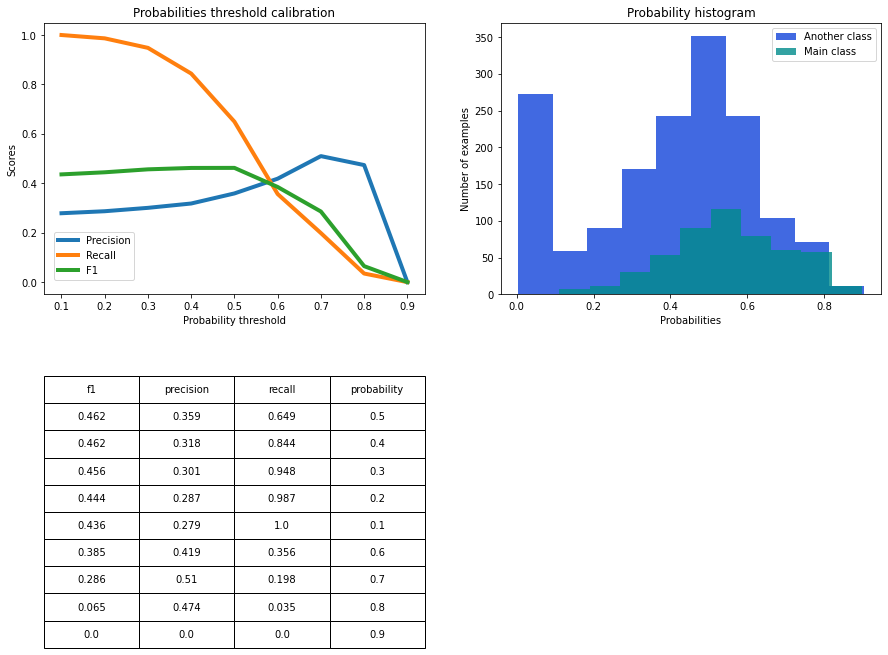

In [248]:
show_proba_calibration_plots(y_test_reduced_pred_probs[:, 1], y_test_reduced)